# Let's solve equation
$$y(x) = \int_a^b K(x, z) \varphi(z)dz,$$
# given measured values $y_i=y(x_i)$ in points $\{x_i\}$ with errors $\delta y_i$ and kernel function $K(x, z)$

for more info see https://mipt-npm.github.io/TurchinReg.jl/dev/

In [1]:
include("../src/TurchinReg.jl")
using .TurchinReg
using BAT, AdvancedHMC, DynamicHMC
using QuadGK

In [2]:
using Plots
plotly()
gr(size=(500,500), html_output_format=:png);

# Loading data:

In [3]:
x_measured = zeros(0)
y_measured = zeros(0)
yerr_measured = zeros(0)
open("9063.dat") do file
    for l in eachline(file)
        x, y, yerr = split(l, "\t")
        push!(x_measured, parse(Float64, convert(String, x)))
        push!(y_measured, parse(Float64, convert(String, y)))
        push!(yerr_measured, parse(Float64, convert(String, yerr)))
    end
end

a = minimum(x_measured)
b = maximum(x_measured)
x_plot = collect(range(a, stop=b, length=500));

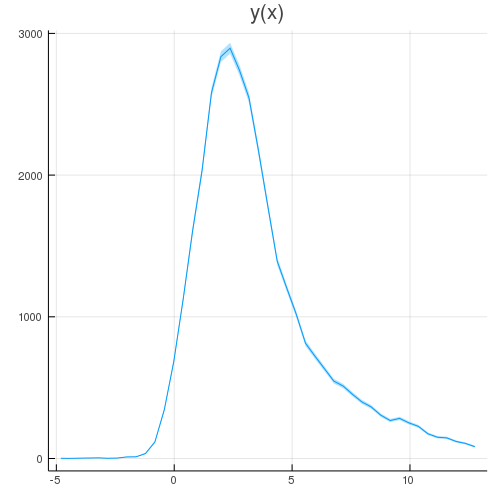

In [4]:
plot(x_measured, y_measured, ribbon=yerr_measured, fillalpha=0.3,
    label="", title="y(x)")

# Define kernel function:

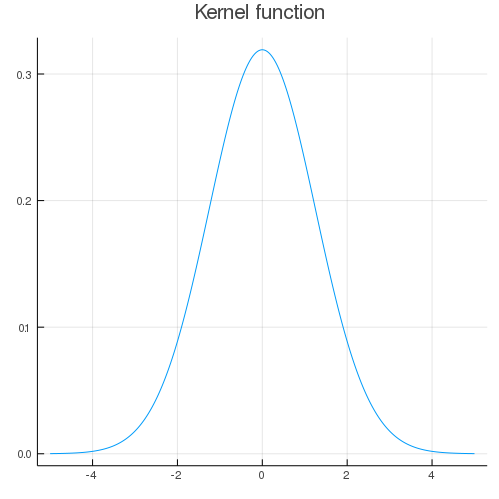

In [5]:
function kernel(x::Real, y::Real)
    sig = 1.25
    return 1 / sqrt(2 * pi*sig^2) * exp(-(x-y)^2 / (2 * sig^2))
end

x_kernel = collect(range(-5, stop=5, length=300))
plot(x_kernel, [kernel(x_, 0) for x_ in x_kernel], label="", title="Kernel function")

# Let's use cubic spline basis $\{T_i(z)\}_{i=1}^N$ with $N=45$ basis functions

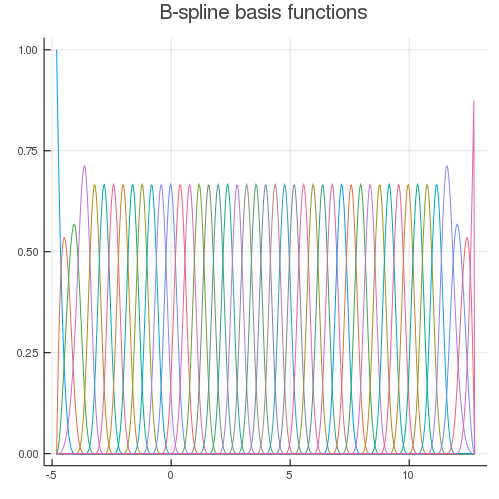

In [6]:
basis = CubicSplineBasis(collect(range(a, stop=b, length=45)));
p = plot()
for func in basis.basis_functions
    p = plot!(x_plot, func.(x_plot), title="B-spline basis functions", legend=false, show = true)
end
display(p)

# $$\Omega_{ij} = \int_a^b \frac{dT_i(z)}{dz} \frac{dT_j(z)}{dz} dz$$
# mean values of second derivatives matrix, needed to introduce additional information about the function

In [7]:
Omega = omega(basis, 2);

┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/bases/cubic_spline.jl:103
┌ Info: Omega caclulated successfully.
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/bases/cubic_spline.jl:117


# Let's use an analysical solution because errors have a poisson distribution

In [8]:
algo = Analytically()

Analytically()

# Regularization parameter is defined as the most probable, for optimization let's use Optim.jl package

In [9]:
alphas = ArgmaxOptim()

ArgmaxOptim(nothing, nothing, nothing, nothing, Optim.BFGS{LineSearches.InitialStatic{Float64},LineSearches.HagerZhang{Float64,Base.RefValue{Bool}},Nothing,Nothing,Optim.Flat}(LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64,Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, nothing, Optim.Flat()))

# For the problem we do not need any bound restrictions

In [10]:
phi_bounds = nothing

# Solution:

┌ Info: Checking data
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:29
┌ Info: Starting discretize kernel...
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/bases/utils.jl:20
┌ Info: Kernel was discretized successfully.
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/bases/utils.jl:32
┌ Info: Finding optimal alpha
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:35
┌ Info: Optimized successfully, alphas = ArgmaxOptim([0.000100006], [0.0001], [10.0], [0.1], Optim.BFGS{LineSearches.InitialStatic{Float64},LineSearches.HagerZhang{Float64,Base.RefValue{Bool}},Nothing,Nothing,Optim.Flat}(LineSearches.InitialStatic{Float64}
│   alpha: Float64 1.0
│   scaled: Bool false
│ , LineSearches.HagerZhang{Float64,Base.RefValue{Bool}}
│   delta: Float64 0.1
│   sigma: Float64 0.9
│   alphamax: Float64 Inf
│   rho: Float64 5.0
│   epsilon: Float64 1.0e-6
│   gamma: Float64 0.66
│   linesear

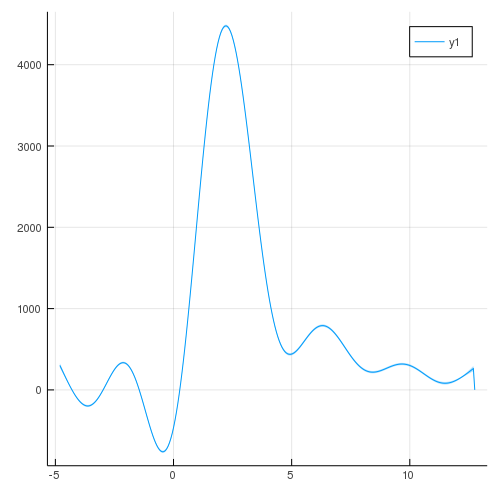

┌ Info: Starting solution
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:54
┌ Info: Solved analytically
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/analytically.jl:5


alpha = 0.0001000055774001702


In [11]:
result = solve(
        basis,
        y_measured,
        yerr_measured,
        kernel,
        x_measured,
        algo,
        alphas,
        [Omega],
        phi_bounds,
        );

x = collect(range(a, stop=b, length=300))
p = plot()

phi_reconstructed = result.solution_function.(x)
phi_reconstructed_errors = result.error_function.(x)
p = plot!(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3)

display(p)
println(string("alpha = ", result.alphas[1]))

# As the most probable value of the parameter, we got $\alpha \approx 10^{-4}$. Let's use another parameter values and plot needed and measured functions.

In [20]:
results = []
for alpha in [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    alphas = User([alpha])
    result = solve(
        basis,
        y_measured,
        yerr_measured,
        kernel,
        x_measured,
        algo,
        alphas,
        [Omega],
        phi_bounds,
        );
    append!(results, [result])
end



┌ Info: Checking data
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:29
┌ Info: Starting discretize kernel...
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/bases/utils.jl:20
┌ Info: Kernel was discretized successfully.
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/bases/utils.jl:32
┌ Info: Finding optimal alpha
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:35
┌ Info: Optimal alpha found
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:37
┌ Info: Starting solution
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:54
┌ Info: Solved analytically
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/analytically.jl:5
┌ Info: Checking data
└ @ Main.TurchinReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:29
┌ Info: Starting discretize kernel...
└ @ Main.TurchinR

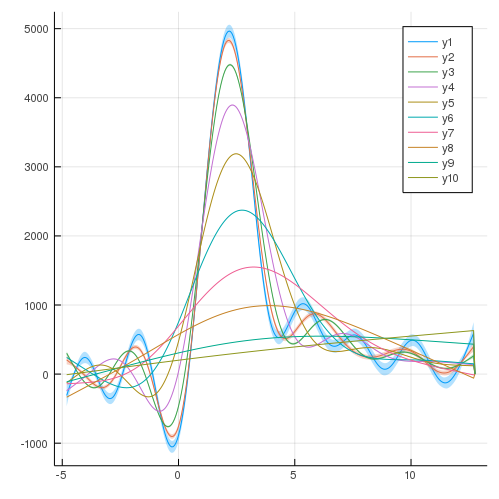

In [22]:
x = collect(range(a, stop=b, length=300))
p = plot()
for result in results
    phi_reconstructed = result.solution_function.(x)
    phi_reconstructed_errors = result.error_function.(x)
    p = plot!(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3)
end
display(p)

loss(alpha = 1.0e-6) = 22751.4576548218
loss(alpha = 1.0e-5) = 23819.46555388683
loss(alpha = 0.0001) = 41134.44274958096
loss(alpha = 0.001) = 205032.30406914558
loss(alpha = 0.01) = 1.0715014358037692e6
loss(alpha = 0.1) = 4.2733492615008e6
loss(alpha = 1.0) = 1.2819882777691085e7
loss(alpha = 10.0) = 2.318131076596474e7
loss(alpha = 100.0) = 3.772969753723378e7
loss(alpha = 

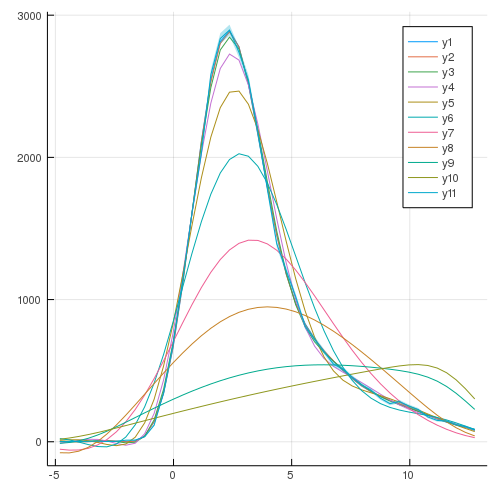

1000.0) = 4.448330147333969e7


In [23]:
p = plot()
for result in results
    function1 = result.solution_function
    convolution = y -> quadgk(x -> kernel(x,y) * function1(x), a, b, rtol=10^-5, maxevals=10^7)[1]
    untegrated_function = convolution.(x_measured)
    pre_loss = [z^2 for z in (untegrated_function - y_measured)]
    loss = sum(pre_loss)
    println("loss(alpha = ", result.alphas[1], ") = ", loss)
    p = plot!(x_measured, untegrated_function)
end
p = plot!(x_measured, y_measured, ribbon=yerr_measured, fillalpha=0.3)
display(p)